In [1]:
import netCDF4
import math
import xarray as xr
import dask
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import transforms
from matplotlib.animation import PillowWriter

In [2]:
path_to_file = '/DFS-L/DATA/pritchard/gmooers/Workflow/MAPS/SPCAM/Small_Sample/New_SPCAM5/TimestepOutput_Neuralnet_SPCAM_216/run/Cpac_gridcell_rcat.nc'
test_ds = xr.open_dataset(path_to_file)
#test_ds.variables

In [3]:
T = np.squeeze(test_ds.T.values)
P = np.squeeze(test_ds.lev.values)
Q = test_ds.QBP.values

Frozen moist static energy

$FSME = \int_0^{P_s}c_p*T+g*z+L_v*q-L_f*q_{ice}$ 

Did not create output in SPCAM for this var - will maybe add to next run?

Potential Temperature, $\theta$

$\theta = T*(\frac{p_0}{p})^{\frac{R}{c_p}}$

In [4]:
def theta_gen(t_array, p_array):
    theta_array = t_array
    for i in range(len(p_array)):
        theta_array[:,i] = t_array[:,i]*(1013.25/p_array[i])**(287.0/1004.0)
    
    return theta_array
        
    

In [5]:
theta = theta_gen(T, P)

In [6]:
def plotting(datas, varname, title, levels):
    plt.plot(datas, levels, linewidth = 4)
    plt.ylabel('Pressure Level', fontsize = 20)
    plt.xlabel(varname, fontsize = 20)
    plt.gca().invert_yaxis()
    plt.title('Snapshot of '+title+' location')

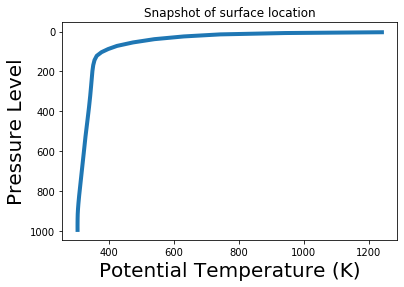

In [7]:
var = 'Potential Temperature (K)'
location = 'surface'
plotting(theta[0, :], var, location, P)

Equivelent Potential Temperature, $\theta_e$

$\theta_e = \theta e^{\frac{L*q}{c_p*T}}$

In [8]:
def theta_e_gen(t_array, q_array, p_array):
    theta_e_array = t_array
    theta_array = theta_gen(t_array, p_array)
    for i in range(len(theta_e_array)):
        for j in range(len(theta_e_array[i])):
            theta_e_array[i, j] = theta_array[i,j]*math.exp((2501000.0*q_array[i,j])/(1004.0*t_array[i,j]))
    
    return theta_e_array
    
    
    

In [9]:
theta_e = theta_e_gen(T, Q, P)

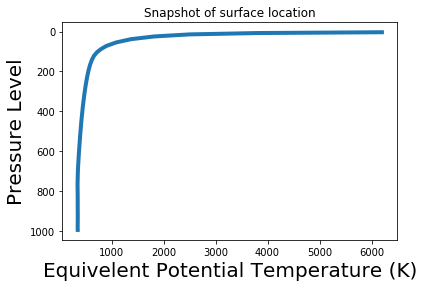

In [10]:
var = 'Equivelent Potential Temperature (K)'
location = 'surface'
plotting(theta_e[0, :], var, location, P)

Integrated Sensible Heat $\frac{w}{m^2}$

$SH = \int_0^{P_s} \frac{dp}{g}*c_p*T$

Not entirely sure if I am using Scipy's built in trapz function correctly, so for now, I will code a function for a numerical implementation of integration via trapziodal rule:

$SH = \frac{cp}{g}\sum_{p=0}^{P_s}\frac{T_i+T_{i+1}}{2}*\delta p_i$

In [11]:
ps = test_ds.PS.values
levs = np.squeeze(test_ds.lev.values)
hyai = test_ds.hyai.values
hybi = test_ds.hybi.values
g = 9.81 
cp = 1004.0
PS = 1e5
P0 = 1e5
P = P0*hyai+PS*hybi # Total pressure [Pa]
dp = P[1:]-P[:-1] # Differential pressure [Pa]
#convert from k/s to w/m^2

In [12]:
def vert_integral(values, diffs):
    integrated = np.zeros(shape=len(values)-1)
    integrated[:] = np.nan
    integrate = 0
    for i in range(len(values)):
        for j in range(len(values[i])-1):
            integrate += 0.5*(values[i,j]+values[i, j+1])*diffs[j]*1004.0/9.81
            
        integrated[i] = integrate
        integrate = 0
    
    return integrated
        

Integrated Latent Heat $\frac{w}{m^2}$

$LH = \int_0^{P_s} \frac{dp}{g}*L_v*q$

Mass Weighted Integral w

$W = \int_0^{P_s}dpw$

In [13]:
W = np.squeeze(test_ds.CRM_W.values)
print(W.shape)

(96, 30, 128)


Integrated Vertical KE

$IVKE = \int_0^{P_s} \frac{dP}{g}*\rho *\frac{w^2}{2}$

